In [1]:
import pickle
import random
import math
import os
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

from tqdm import tqdm
import torch.optim as optim
import torchvision.transforms.functional as F

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Training best model on all training data

In [2]:
#################################################################################################### Imports
import pickle
import random
import math
import os
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tqdm import tqdm
import torch.optim as optim
import torchvision.transforms.functional as F

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#################################################################################################### Load Pickle Files
def trim_array(arr):
    if np.all(arr == 0):  # Check if the array is all zeros
        return arr
    first_non_zero = np.argmax(arr != 0)
    last_non_zero = len(arr) - np.argmax(arr[::-1] != 0)
    return arr[first_non_zero:last_non_zero]

allaudios = [] # Creates an empty list
for root, dirs, files in os.walk("train"):
    i=0 
    for file in files:
        if file.endswith(".pkl"):
           audio = file
           openaudios = open(os.getcwd() + "/train/" + audio, 'rb')
           loadedaudios = pickle.load(openaudios)
           
           allaudios.append(loadedaudios)
           i+=1
        #    if i==1000:
        #        break

audio_data = []
valence = []
audio_lengths = []
for audio in allaudios:
    # Get Rid of front and end trailing zeros
    audio_trimmed = trim_array(audio['audio_data'])
    audio_data.append(audio_trimmed)

    audio_length = len(audio_trimmed)
    audio_lengths.append(audio_length)
    valence.append(audio['valence'])


mean_length = np.mean(audio_lengths)
median_length = np.median(audio_lengths)
std_dev = np.std(audio_lengths)
min_length = np.min(audio_lengths)
max_length = np.max(audio_lengths)

#################################################################################################### Pad / Truncation (get all audio the same length)
def pad_trunc_audio(audio_data, target_length = int(np.percentile(audio_lengths, 95))):
    standardized_data = []
    for data in audio_data:
        if len(data) < target_length:
            padded_data = np.pad(data, (0, target_length - len(data)), 'constant', constant_values=(0, 0))
            standardized_data.append(padded_data)
        elif len(data) > target_length:
            truncated_data = data[:target_length]
            standardized_data.append(truncated_data)
        else:
            standardized_data.append(data)
    return standardized_data

standardized_audios = pad_trunc_audio(audio_data)
print("Done padding")

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", torch.tensor(mean))
        self.register_buffer("std", torch.tensor(std))

    def forward(self, x):
        with torch.no_grad():
            x = x - self.mean
            x = x / self.std
        return x

#################################################################################################### DataLoader Creation
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

size_train = int(round(len(standardized_audios) * 0.8))
X_train = standardized_audios[:size_train]
X_test = standardized_audios[size_train:]
y_train = valence[:size_train]
y_test = valence[size_train:]

flatten = np.concatenate(X_train)
mean = np.mean(flatten)
std = flatten.std()
normalization = Normalization(mean, std)

batch_size = 64

train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,) # you can speed up the host to device transfer by enabling pin_memory.
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True,) # you can speed up the host to device transfer by enabling pin_memory.

print("Done with data loaders")
#################################################################################################### Model Architecture
class CNN1d(nn.Module):
    def __init__(self, pre_proocesses, hidden_sizes, activation_function):

        super(CNN1d, self).__init__()

        self.hidden_sizes = hidden_sizes
        self.activation_function = activation_function

        self.width = 128

        self.layers = nn.ModuleList()

        # # add preprocessing steps
        # for process in pre_proocesses:
        #     self.layers.append(process)

        self.layers.append(normalization)

        for i in range(len(self.hidden_sizes)):
            self.layers.append(nn.Conv1d(1 if i ==0 else self.hidden_sizes[i-1], self.hidden_sizes[i], kernel_size=3))
            self.layers.append(nn.BatchNorm1d(self.hidden_sizes[i], eps=.00001, momentum=0.1, affine=True, track_running_stats=True))
            self.layers.append(nn.MaxPool1d(kernel_size=3))
            self.layers.append(self.activation_function())


        self.layers.append(nn.AdaptiveAvgPool1d(1))
        self.layers.append(nn.Flatten()) 
        self.layers.append(nn.Linear(in_features=self.hidden_sizes[-1], out_features=self.width))
        self.layers.append(nn.Dropout(p=0.5))
        self.layers.append(nn.Linear(in_features=self.width, out_features=1))

    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
#################################################################################################### Train Model Loop
def calculate_metrics(actual, predicted):

    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    
    return {
        "Mean Absolute Error (MAE)": mae,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "R-squared (R^2)": r2
    }

def loss_plot(train_loss, validation_loss, filename):
    epochs = range(1, len(train_loss) + 1) # start at 1 instead of 0
    # Plotting the training and validation losses
    plt.figure(figsize=(5, 5))
    plt.plot(epochs, train_loss, label='Training Loss', color='blue')
    plt.plot(epochs, validation_loss, label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(filename)
    plt.show()
    

def train_model(net, optimizer, train_loader, val_loader, epochs):
    # Define the loss function
    criterion = nn.MSELoss()
    # Define the optimizer

    train_loss_lst = []
    val_loss_lst = []

    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        # Iterate over training batches
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
            for audio, valence in train_loader:
                optimizer.zero_grad()  # Reset gradients
                valence = valence.float() # was double 

                audio = audio.unsqueeze(1) # [batch, channel=1, 128,145]
                audio, valence = audio.to(device), valence.to(device)

                outputs = net(audio)
                outputs = outputs.squeeze()  # Reshape the output to match target
                loss = criterion(outputs, valence)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                pbar.set_postfix({'loss': running_loss / (len(pbar) + 1)})  # Display average loss
                pbar.update(1)  # Update the progress bar

        train_loss = running_loss / len(train_loader)
        train_loss_lst.append(train_loss)

        # Validation
        net.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for audio, valence in val_loader:
                valence = valence.float() # was double

                audio = audio.unsqueeze(1) # [batch, channel=1, 128,145]
                audio, valence = audio.to(device), valence.to(device)
                outputs = net(audio)
                outputs = outputs.squeeze()  # Reshape the output to match target
                val_loss = criterion(outputs, valence)
                val_running_loss += val_loss.item()

        val_loss = val_running_loss / len(val_loader)
        val_loss_lst.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
    #display loss graph
    # loss_plot(train_loss_lst, val_loss_lst, "")
    print("Training for CNN is finished.")

    return train_loss_lst, val_loss_lst


#################################################################################################### Run and Save Best model
# model_best = CNN1d([], best_coarse_params['hidden_size'], nn.ReLU).to(device)
# optimizer = optim.Adagrad(model_best.parameters(), lr=best_coarse_params['lr'])
# train_loss_lst, val_loss_lst = train_model(model_best, optimizer, train_dataloader, test_dataloader, 20)
# loss_plot(train_loss_lst, val_loss_lst, f"best_model_hidden_size_{hidden_sizes}_lr_{learning_rate:.4}_epochs_{num_epochs}.png")




Done padding
Done with data loaders


Epoch 1/10: 100%|██████████| 132/132 [02:28<00:00,  1.13s/batch, loss=1.05] 


Epoch 1/10, Train Loss: 1.0575, Val Loss: 0.6016


Epoch 2/10: 100%|██████████| 132/132 [02:40<00:00,  1.22s/batch, loss=0.695]


Epoch 2/10, Train Loss: 0.7006, Val Loss: 0.6124


Epoch 3/10: 100%|██████████| 132/132 [02:44<00:00,  1.24s/batch, loss=0.652]


Epoch 3/10, Train Loss: 0.6571, Val Loss: 0.6040


Epoch 4/10: 100%|██████████| 132/132 [02:45<00:00,  1.25s/batch, loss=0.635]


Epoch 4/10, Train Loss: 0.6402, Val Loss: 0.5896


Epoch 5/10: 100%|██████████| 132/132 [02:57<00:00,  1.34s/batch, loss=0.607]


Epoch 5/10, Train Loss: 0.6112, Val Loss: 0.5107


Epoch 6/10: 100%|██████████| 132/132 [02:51<00:00,  1.30s/batch, loss=0.605]


Epoch 6/10, Train Loss: 0.6098, Val Loss: 0.5484


Epoch 7/10: 100%|██████████| 132/132 [02:53<00:00,  1.31s/batch, loss=0.59] 


Epoch 7/10, Train Loss: 0.5946, Val Loss: 0.5089


Epoch 8/10: 100%|██████████| 132/132 [02:56<00:00,  1.34s/batch, loss=0.589]


Epoch 8/10, Train Loss: 0.5932, Val Loss: 0.6633


Epoch 9/10: 100%|██████████| 132/132 [02:55<00:00,  1.33s/batch, loss=0.575]


Epoch 9/10, Train Loss: 0.5798, Val Loss: 0.5188


Epoch 10/10: 100%|██████████| 132/132 [03:06<00:00,  1.42s/batch, loss=0.567]


Epoch 10/10, Train Loss: 0.5716, Val Loss: 0.5954
Training for CNN is finished.


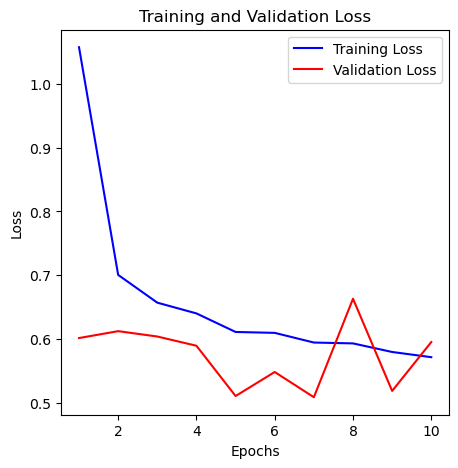

In [3]:
model_best = CNN1d([], [16,16,32,32,64,64,128], nn.ReLU).to(device)
optimizer = optim.Adagrad(model_best.parameters(), lr=0.0018969)
train_loss_lst, val_loss_lst = train_model(model_best, optimizer, train_dataloader, test_dataloader, 10)
loss_plot(train_loss_lst, val_loss_lst, f"best_model_hidden_size_[16 16,32,32,64,64,128]_lr_{0.0018969:.4}_epochs_{10}.png")

save_path = "best_coarse_model_adam_10_epochs_with_normalization.pth"

torch.save(model_best, save_path)

# Load In Model

In [4]:
class CNN1d(nn.Module):
    def __init__(self, pre_proocesses, hidden_sizes, activation_function):

        super(CNN1d, self).__init__()

        self.hidden_sizes = hidden_sizes
        self.activation_function = activation_function

        self.width = 128

        self.layers = nn.ModuleList()

        # # add preprocessing steps
        # for process in pre_proocesses:
        #     self.layers.append(process)

        self.layers.append(normalization)

        for i in range(len(self.hidden_sizes)):
            self.layers.append(nn.Conv1d(1 if i ==0 else self.hidden_sizes[i-1], self.hidden_sizes[i], kernel_size=3))
            self.layers.append(nn.BatchNorm1d(self.hidden_sizes[i], eps=.00001, momentum=0.1, affine=True, track_running_stats=True))
            self.layers.append(nn.MaxPool1d(kernel_size=3))
            self.layers.append(self.activation_function())


        self.layers.append(nn.AdaptiveAvgPool1d(1))
        self.layers.append(nn.Flatten()) 
        self.layers.append(nn.Linear(in_features=self.hidden_sizes[-1], out_features=self.width))
        self.layers.append(nn.Dropout(p=0.5))
        self.layers.append(nn.Linear(in_features=self.width, out_features=1))

    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
model = torch.load("best_coarse_model_adam_10_epochs_with_normalization.pth")

# Test Data

In [6]:
# Function to process a single pickle file and return the filename and prediction
def process_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    #apply preprocessing
    audio_data = data["audio_data"]
    audio_trimmed = trim_array(audio_data)
    
    audio_pad_trunced = pad_trunc_audio([audio_trimmed])
    audio_data_tensor = torch.tensor(audio_pad_trunced).unsqueeze(0)

    # print(f"Original shape: {audio_data.shape}")
    # print(f"Trimmed shape: {audio_trimmed.shape}")
    # print(f"Pad/Truncated shape: {len(audio_pad_trunced[0])}")
    # print(f"Tensor shape: {audio_data_tensor.shape}")


    valence = model(audio_data_tensor).item()
    return os.path.basename(file_path), valence

# List to store results
results = []

# Iterate through all files in the folder
for filename in os.listdir("test"):
    if filename.endswith('.pkl'):
        file_path = os.path.join("test", filename)
        file_id, valence = process_file(file_path)
        results.append((file_id, valence))

# Create a DataFrame for better visualization and potential saving to CSV
results_df = pd.DataFrame(results, columns=['ID', 'valence'])

# Save results to a CSV file
results_df.to_csv('results_group42_a1.csv', index=False)

results_df

,ID,valence
0,10011.pkl,3.173593
1,10025.pkl,2.587912
2,10033.pkl,4.055475
3,10036.pkl,2.983720
4,10043.pkl,3.717566
...,...,...
1858,22393.pkl,3.067180
1859,22394.pkl,3.084748
1860,22400.pkl,3.276754
1861,22401.pkl,2.928008
